# Charged Particles

This notebook focuses on finding a perfect distribution of charged particles over a spherical disk. This can be viewed as a petri dish consisting of positively charged potassium particles ($K^+$) under pressure. The particles are repelling each other whilst being confined within the space of the petri dish. The question then arises, what would be the optimal distribution of these particles, energetically speaking, on this petri dish such that the energy within the system is minimized? This question is complex as it means finding the absolute minimum of the potential energy landscape in this two-dimensional configuration space. The method used for addressing this issue is called the simulated annealing technique. This technique is an elaboration on the hill climber technique where an algorithm is used to essentially "walk around the fitness landscape", in the sense that small perturbations are administered after which a score function calculates the fitness of the current solution. If this solution is better then the previous one, the solution is accepted and used for the next iteration of perturbation. The simulated annealing technique elaborates on this by using a "temperature" to accept worse solutions. The chance of accepting worse solutions depends on this temperature which cools down (declines) in the passage of time. The idea behind this is that upon being stuck inside a local minimum, the algorithm has a chance to escape. Six different cooling schemes are used (Hillclimber, Sigmoid, Exponential, variant of Exponential, Binary, Linear).

## Load libraries and functions

In [55]:
import scipy.optimize as so
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
from IPython.display import IFrame, display, HTML, Markdown
import random
import math
import seaborn as sns
import pickle


def prettyfie(ax, x, y, title, legendYN='Yes'):

    # Remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(alpha=0.25)

    # Remove unnecessary ticks
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)

    if legendYN == 'Yes':
        # Create legend and grid
        ax.legend(framealpha=1, shadow=True, prop={'size': 14})
        ax.legend()

    # Set labels and title
    ax.set_xlabel(x, fontsize=16)
    ax.set_ylabel(y, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)


def printmd(string):
    display(Markdown(string))


def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)  # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name, index=index)
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name, index=index, size=size)
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name, index=str(index or '?'))


def plot(coordList):
    plt.rcParams['figure.figsize'] = [10, 10]
    sns.set()
    sns.set_style("dark")
    fig = plt.figure()
    ax = plt.subplot(111)
    colors = list(range(len(coordList)))
    ax.scatter(coordList[:, 0], coordList[:, 1], c=colors, cmap='Dark2')
    circle1 = plt.Circle((0, 0), radius, alpha=0.2, color="olive")
    ax.add_artist(circle1)
    plotpretify(
        ax,
        1.1,
        minx=-1.1,
        miny=-1.1,
        maxy=1.1,
        Grid=False,
        LL=False,
        LB=False)


def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: #b3fcd0' if v else '' for v in is_min]


def getScheme_data(iters, plot="No", scheme="Sigmoid", markovChain=1):

    answer = []

    if scheme == "Sigmoid":
        linspace = np.linspace(0, 7, iters)
        for x in linspace:
            answer.append(0.5 +
                          math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    elif scheme == "Exp":
        for x in range(iters):
            answer.append(np.exp(-x / (iters / 10)))
    elif scheme == "Expvar":
        for x in range(iters):
            answer.append(
                max(
                    np.exp(-x / iters) - ((1.5 * x) / iters) * (1 / math.e),
                    0))
    elif scheme == "Expvar2":
        for x in range(iters):
            answer.append(max(np.exp(-x / iters) - 1.1 * (1 / math.e), 0))
    elif scheme == "Hillclimb":
        for x in range(iters):
            answer.append(0)
    elif scheme == "Binary":
        for x in range(iters):
            if x < iters / 2:
                answer.append(1)
            else:
                answer.append(0)
    elif scheme == "Linear":
        for x in range(iters):
            answer.append(1 - (x / iters))
    else:
        raise ValueError(
            "You've picked a wrong cooling scheme, try: Sigmoid, Exp, Expvar, Expvar2, Hillclimb,Binary or Linear"
        )

    if plot == "Yes":
        plotanswer = np.repeat(answer, markovChain)
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        ax.plot(plotanswer, label="Acceptance chance")
        ax.legend()
        prettyfie(ax, "iteration", "Acceptance", scheme, legendYN="Yes")
        plt.show()
    return np.array(answer)


def incircle(crds, r=1):
    return np.power(crds[0], 2) + np.power(crds[1], 2) < r


def spawn(r=1):
    x = random.uniform(-r, r)
    limits = [-np.sqrt(r**2 - x**2), np.sqrt(r**2 - x**2)]
    y = random.uniform(limits[0], limits[1])
    return [x, y]


# Good score when somewhere < 2
def checkScore(coord):
    totalDist = 0
    for i in range(len(coord)):
        for j in range(i, len(coord)):
            if i != j:
                totalDist += 1 / abs(
                    math.hypot(coord[j][0] - coord[i][0],
                               coord[j][1] - coord[i][1]))
    return totalDist


def move(k, coord, temp, rate):
    F = np.array([0.0, 0.0])
    velocity = np.zeros(2, float)
    for l in coord:
        if any(l != k):
            r = np.array(k) - np.array(l)
            F1 = (r / (np.linalg.norm(r)**3) * rate)
            F += F1
    newPoint = k + F
    xr = random.uniform(-1, 1) * (1 / 50)
    yr = random.uniform(-1, 1) * (1 / 50)
    newPoint += [xr, yr]
    if not incircle(newPoint, radius):
        newPoint = newPoint / la.norm(newPoint)
    return newPoint, F


def submove(k, i, coord, temp, rate, score):
    global coordListList
    cT, favo = move(k, coord, temp, rate)
    coordTemp = np.copy(coord)
    coordTemp[i] = cT
    coordListList.append(coordTemp)
    scoreTemp = checkScore(coordTemp)
    if temp > 0:
        chance = np.exp(-(scoreTemp - score) / temp)
    else:
        chance = 0
    if score > scoreTemp:
        return np.array(coordTemp), favo
    elif chance > random.random():
        return np.array(coordTemp), favo
    else:
        return coord, favo


def changeCoordSingle(coord, temp, rate):
    score = checkScore(coord)
    fav = []
    for i, k in enumerate(coord):
        coord, favo = submove(k, i, coord, temp, rate, score)
        fav.append(favo)
    return coord


def changeCoordAll(coord, temp, rate):
    counter = 0
    score = checkScore(coord)
    while counter < 10:
        fav = []
        coordTemp = []
        for i, k in enumerate(coord):
            cT, favo = move(k, coord, temp, rate)
            coordTemp.append(cT)
            fav.append(favo)
        scoreTemp = checkScore(coordTemp)
        if temp > 0:
            chance = np.exp(-(scoreTemp - score) / temp)
        else:
            chance = 0
        if score > scoreTemp:
            return np.array(coordTemp)
        elif chance > random.random():
            return np.array(coordTemp)
    return coord


def start_sim(coordList,
              radius,
              pointsNum,
              iterations,
              rate,
              scheme,
              markovChain,
              moveScheme,
              transition="No",
              plotScheme="No"):

    schemeData = np.repeat(
        getScheme_data(
            math.ceil(iterations / markovChain),
            plot=plotScheme,
            scheme=scheme), markovChain)
    checklist=[]
    coordListList = []
    coordListList.append(coordList)
    for i in range(iterations):
        temp = schemeData[i]
        coordList = moveScheme(coordList, temp, rate)
        checklist.append(checkScore(coordList))
        coordListList.append(coordList)

    if transition == "Yes":
        return checklist, coordListList
    else:
        return checklist

## Run all

In [33]:

coordListList = []

radius = 1
pointsNums = list(range(11, 31))
iterations = 2000
rate = math.pow(10, -4)
schemes = ["Hillclimb", "Sigmoid", "Exp", "Expvar", "Binary", "Linear"]
checks = []
coordListListList = []
results = {}
mcl = [1, 10, 100]
moveScheme = changeCoordSingle
transition = "Yes"

data = []
rowcount = 0
for i, scheme in enumerate(schemes):
    printmd(f"### scheme: {scheme}")
    for j, markovL in enumerate(mcl):
        data.append([])
        printmd(f"### Markovlength: {markovL}")
        getScheme_data(
            math.ceil(iterations / markovL),
            plot="Yes",
            scheme=scheme,
            markovChain=markovL)
        for pointsNum in log_progress(
                pointsNums, every=1, size=len(pointsNums), name='Items'):
            random.seed(147)
            coordList = []
            for i in range(pointsNum):
                coordList.append(spawn(radius))
            coordList = np.array(coordList)
            if transition == "Yes":
                checklist, coordListList = start_sim(
                    coordList,
                    radius,
                    pointsNum,
                    iterations,
                    rate,
                    scheme,
                    markovL,
                    moveScheme,
                    transition,
                    plotScheme="No")
            else:
                checklist = start_sim(
                    coordList,
                    radius,
                    pointsNum,
                    iterations,
                    rate,
                    scheme,
                    markovL,
                    moveScheme,
                    transition,
                    plotScheme="No")
            data[rowcount].append(checklist[-1])
        rowcount += 1

schemas = ["Mean"]
mcls = [""]
for i, scheme in enumerate(schemes):
    for ml in mcl:
        schemas.append(scheme)
        mcls.append(ml)
arrays = [schemas, mcls]

tuples = list(zip(*arrays))
data.insert(0, [0 for i in range(len(data[0]))])

index = pd.MultiIndex.from_tuples(tuples, names=['Scheme', 'MarkovLength'])
s = pd.DataFrame(data, index=index, columns=pointsNums)
meanRow = [np.mean(s[i][1:]) for i in pointsNums]
p = s - meanRow
for i in pointsNums:
    p[i][0] = abs(p[i][0])
final =  p.round(3).T.style.apply(highlight_min, axis=1)
display(final)

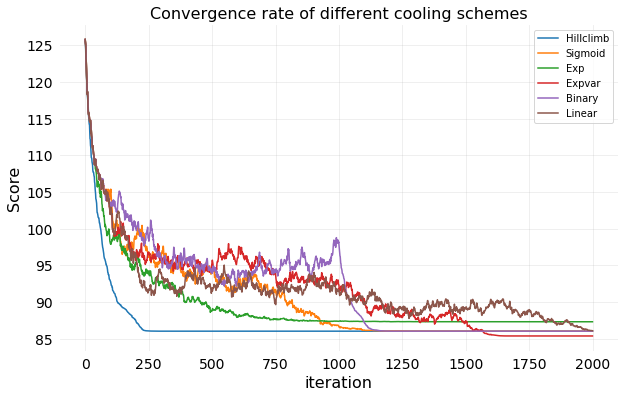

In [57]:
coordListList = []

radius = 1
pointsNum = 14
iterations = 2000
rate = math.pow(10, -4)
schemes = ["Hillclimb", "Sigmoid", "Exp", "Expvar", "Binary", "Linear"]
checks = []
checklist = []
coordListListList = []
results = {}
mcl = [1]
moveScheme = changeCoordSingle
transition = "No" # yes if you want data for the sliding pictures

data = []
rowcount = 0
for i, scheme in enumerate(schemes):
    for j, markovL in enumerate(mcl):
        random.seed(147)
        coordList = []
        for i in range(pointsNum):
            coordList.append(spawn(radius))
        coordList = np.array(coordList)
        checklist = start_sim(
            coordList,
            radius,
            pointsNum,
            iterations,
            rate,
            scheme,
            markovL,
            moveScheme,
            transition,
            plotScheme="No")
        data.append(checklist)
        rowcount += 1
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
[ax.plot(check, label=schemes[i]) for i, check in enumerate(data)]
ax.legend()
prettyfie(ax, "iteration", "Score", "Convergence rate of different cooling schemes", legendYN="Yes")
plt.show()

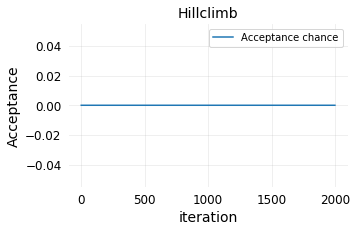

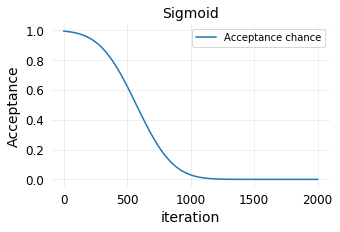

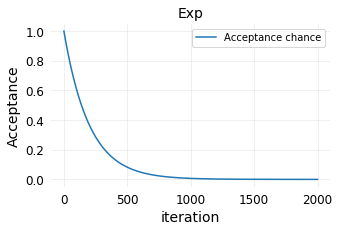

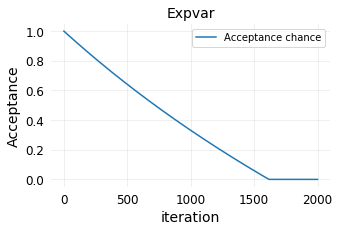

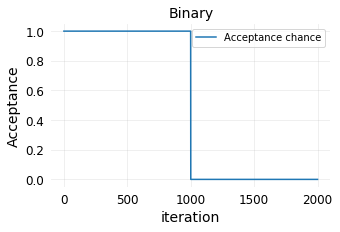

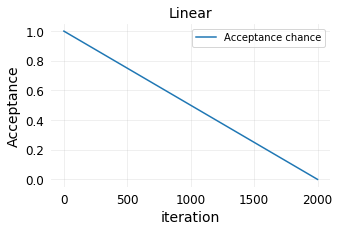

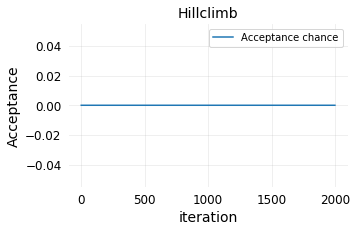

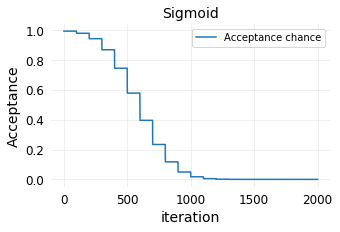

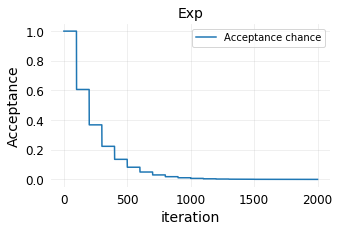

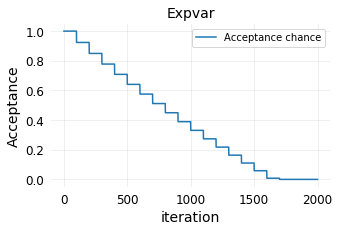

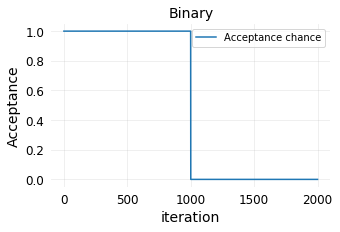

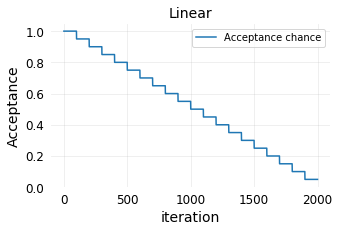

In [27]:
iterations = 2000
markovs = [1,100]
schemes = ["Hillclimb", "Sigmoid", "Exp", "Expvar", "Binary", "Linear"]
for markovL in markovs:
    for scheme in schemes:
        getScheme_data(
            math.ceil(iterations / markovL),
            plot="Yes",
            scheme=scheme,
            markovChain=markovL)

## Load data from large run and create pictures of results

In [58]:
import pandas as pd
finalData = pd.read_pickle("finalPickle.pkl")
final =  finalData.round(3).T.style.apply(highlight_min, axis=1)
display(final)

<function matplotlib.pyplot.show(*args, **kw)>

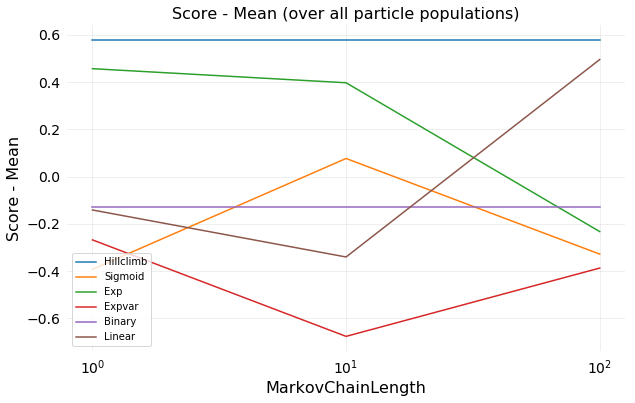

In [59]:
schemes = ["Hillclimb", "Sigmoid", "Exp", "Expvar", "Binary", "Linear"]
markovLengths = [1,10,100]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for scheme in schemes:
    data = []
    std = []
    for i in markovLengths:
        data.append(finalData.xs((scheme,i)).mean())
        std.append(finalData.xs((scheme,i)).std())
    ax.semilogx(markovLengths, data, label=scheme)
    ax.legend()
prettyfie(ax, "MarkovChainLength", "Score - Mean", "Score - Mean (over all particle populations)", legendYN="Yes")
plt.show

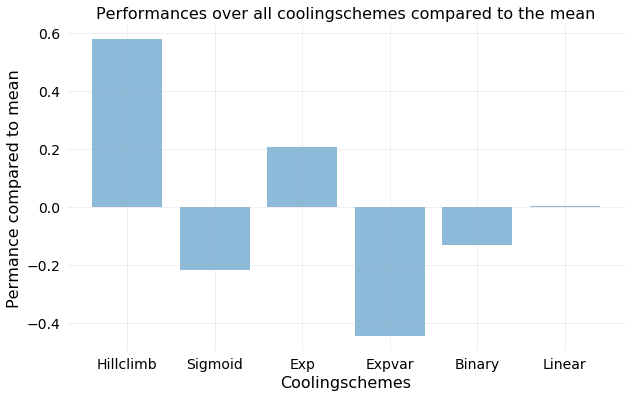

In [60]:
schemes = ["Hillclimb", "Sigmoid", "Exp", "Expvar", "Binary", "Linear"]
markovLengths = [1,10,100]
data = []
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for scheme in schemes:
    data.append(finalData.xs(scheme).mean().mean())
y_pos = np.arange(len(schemes))
ax.bar(y_pos, data, align='center', alpha=0.5)
plt.xticks(y_pos, schemes)
prettyfie(ax, "Coolingschemes", 'Permance compared to mean', "Performances over all coolingschemes compared to the mean", legendYN="No")
plt.show()

In [62]:
radius = 1
pointsNum = 14
iterations = 750
rate = math.pow(10, -4)
scheme = "Expvar"
checks = []
results = {}
markovL = 1
moveScheme = changeCoordSingle
transition = "No"

getScheme_data(
    math.ceil(iterations / markovL),
    plot="Yes",
    scheme=scheme,
    markovChain=markovL)

scores = []
for i in range(1000):
    if i%100 == 0: print(i)
    coordList = []
    for i in range(pointsNum):
        coordList.append(spawn(radius))
    coordList = np.array(coordList)
    checklist = start_sim(
        coordList,
        radius,
        pointsNum,
        iterations,
        rate,
        scheme,
        markovL,
        moveScheme,
        transition,
        plotScheme="No")
    scores.append(checklist[-1])
with open('scores.pkl', 'wb') as f:
    pickle.dump(scores, f)

In [ ]:
with open('scores.pkl', 'rb') as f:
    scores = pickle.load(f)

In [64]:
from scipy import stats

scorez = np.array(scores)
print(np.mean(scorez), np.std(scorez))

k2, p = stats.normaltest(scorez)
alpha = 0.05
print("p = {:g}".format(p))
print("k = {:g}".format(k2))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The distribution is not normally distributed")
else:
    print("The distribution is normally distributed")


86.58129315181463 0.6557965326102081
p = 0.177657
k = 3.4558
The distribution is normally distributed


## Create slider video from iterations

![Alt Text](charged_particles_2.gif)

In [ ]:
radius = 1
pointsNum = 40
iterations = 200
rate = math.pow(10, -4)
scheme = "Sigmoid"
checks = []
results = {}
markovL = 10
moveScheme = changeCoordSingle
transition = "Yes"

getScheme_data(
    math.ceil(iterations / markovL),
    plot="Yes",
    scheme=scheme,
    markovChain=markovL)

random.seed(147)
coordList = []
for i in range(pointsNum):
    coordList.append(spawn(radius))
coordList = np.array(coordList)
checklist, coordListList = start_sim(
    coordList,
    radius,
    pointsNum,
    iterations,
    rate,
    scheme,
    markovL,
    moveScheme,
    transition,
    plotScheme="No")

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]


def plotpretify(ax,
                maxx,
                minx=0,
                miny=None,
                maxy=None,
                Grid=True,
                LB=True,
                LL=True):
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)
    #     ax.grid(True)

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)


sns.set()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


def showPlot(i=0):
    plot(coordListList[i])


y = interactive(showPlot, i=(0, len(coordListList) - 1, 1))
display(y)